In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import signal

In [147]:
stats = pd.read_csv('stats.csv')
stats.columns

Index(['date', 'business', 'category', 'item_description', 'document',
       'document_ID', 'client_name', 'packaging', 'unit_cost', 'sold_quantity',
       'total_cost', 'unit_price', 'total_sale_price', 'delivery_price',
       'gross_profit', 'total_taxes', 'total_tax_retention', 'current_balance',
       'amount_paid', 'payment_dates', 'gross_profit_percentage', 'address',
       'client_ID', 'item_ID', 'year_extracted', 'month_extracted',
       'day_extracted'],
      dtype='object')

In [148]:
def time_series_plot(df):
    # This functions is use to create the time series from each item that is been sold
    # what is doing is that grab the actual day of the register and concatenating the
    # year and week putting x-axis = Week of the Year and y-axis = the added quantity sold per week per year
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['item_description'] == 'Botella_750ml']
    
    df = df[['year_extracted','date', 'item_description','unit_cost','unit_price', 'sold_quantity']]
    df['first_day_of_month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    df = df.groupby(['first_day_of_month','item_description']).agg({'unit_cost': 'mean', 'sold_quantity': 'sum', 'unit_price': 'mean'}).reset_index()

    n = len(pd.unique(df['item_description']))
    item_description = pd.unique(df['item_description'])

    fig, axs = plt.subplots(nrows=n, ncols=1, figsize=(30, 5 * n), dpi=80)
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle("Amount of quantities sold per week", fontsize=18, y=0.99)
    
    if n == 1:  
        axs = [axs]

    for idx, item in enumerate(item_description):
        item_data = df[df['item_description'] == item]
        ax = axs[idx]
        ax.plot(item_data['first_day_of_month'], item_data['unit_cost'], marker='o')
        ax.plot(item_data['first_day_of_month'], item_data['unit_price'], marker='o')
        ax.plot(item_data['first_day_of_month'], item_data['sold_quantity'], marker='o')
        ax.set_title(item.upper())
        ax.set_xlabel("Year Week")
        ax.set_ylabel("Quantities that has been sold")
        
        ax.grid(True)

    plt.show()

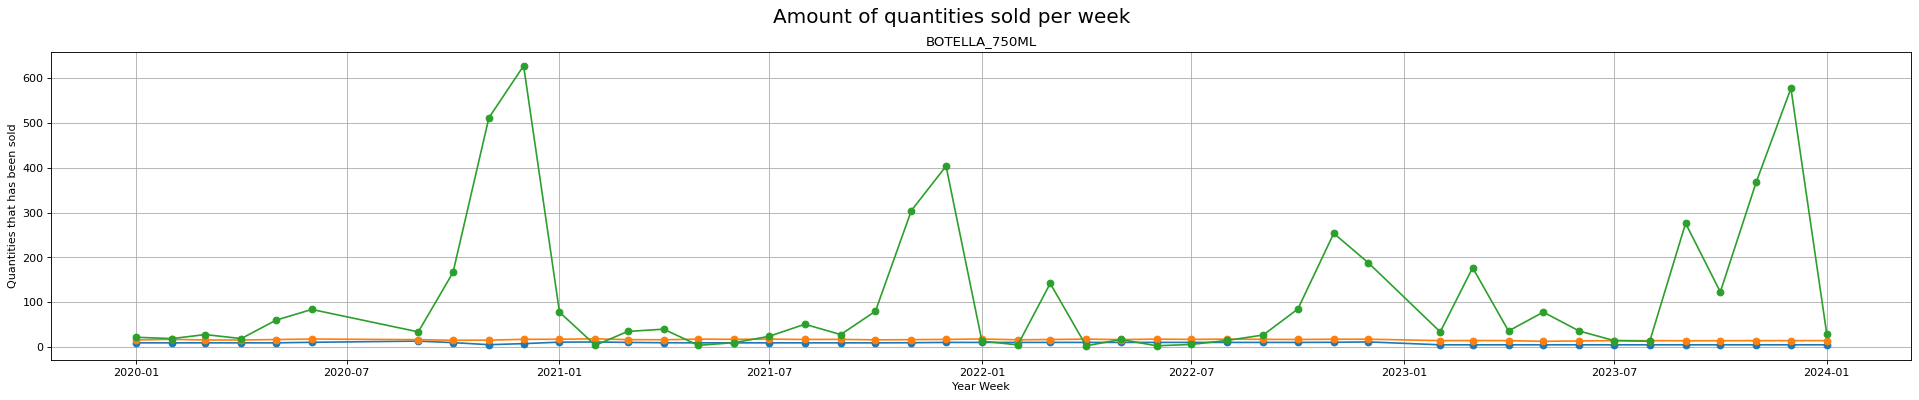

In [149]:
time_series_plot(stats)

In [150]:
def distribution_plot(df):

    df['date'] = pd.to_datetime(df['date'])
    df = df[df['item_description'] == 'Botella_750ml']
    
    df = df[['year_extracted','date', 'item_description','unit_cost','unit_price', 'sold_quantity']]
    df['first_day_of_month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    df = df.groupby(['first_day_of_month','item_description']).agg({'unit_cost': 'mean', 'sold_quantity': 'sum', 'unit_price': 'mean'}).reset_index()

    n = len(pd.unique(df['item_description']))
    item_description = pd.unique(df['item_description'])

    print(df.shape)

    fig, axs = plt.subplots(nrows=n, ncols=1, figsize=(30, 5 * n), dpi=80)
    plt.subplots_adjust(hspace=0.5)
    
    if n == 1:  
        axs = [axs]

    for idx, item in enumerate(item_description):
        item_data = df[df['item_description'] == item]
        ax = axs[idx]
        sns.histplot(item_data['sold_quantity'], kde=True, ax=ax)
        ax.set_title(item.upper())
        ax.set_xlabel("Quantities")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    plt.show()

(46, 5)


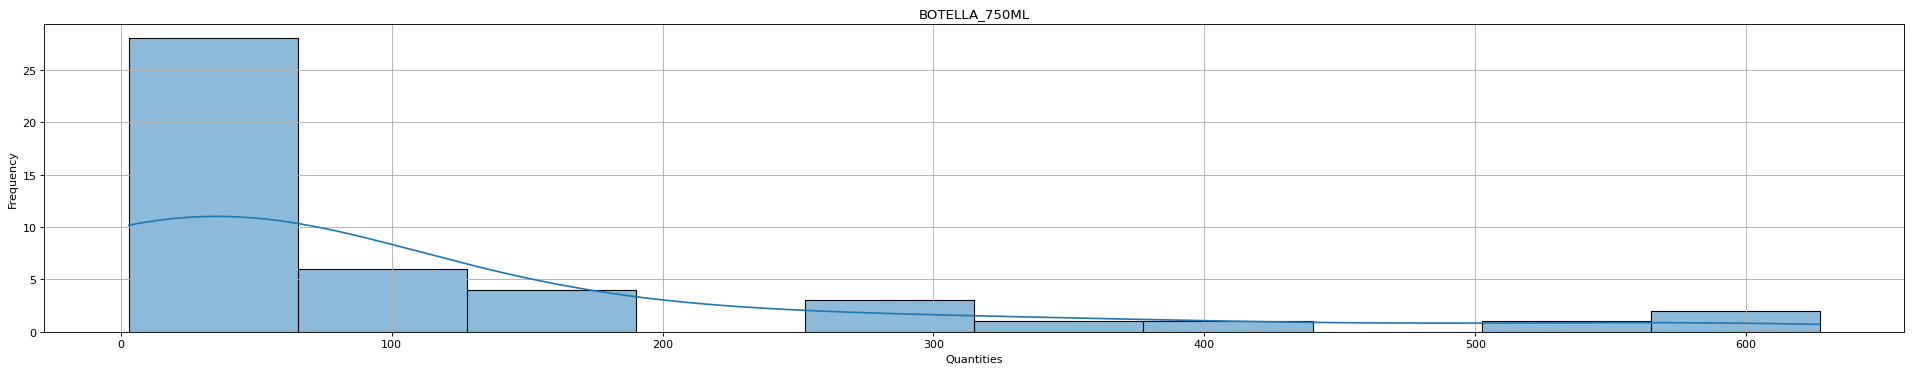

In [151]:
distribution_plot(stats)

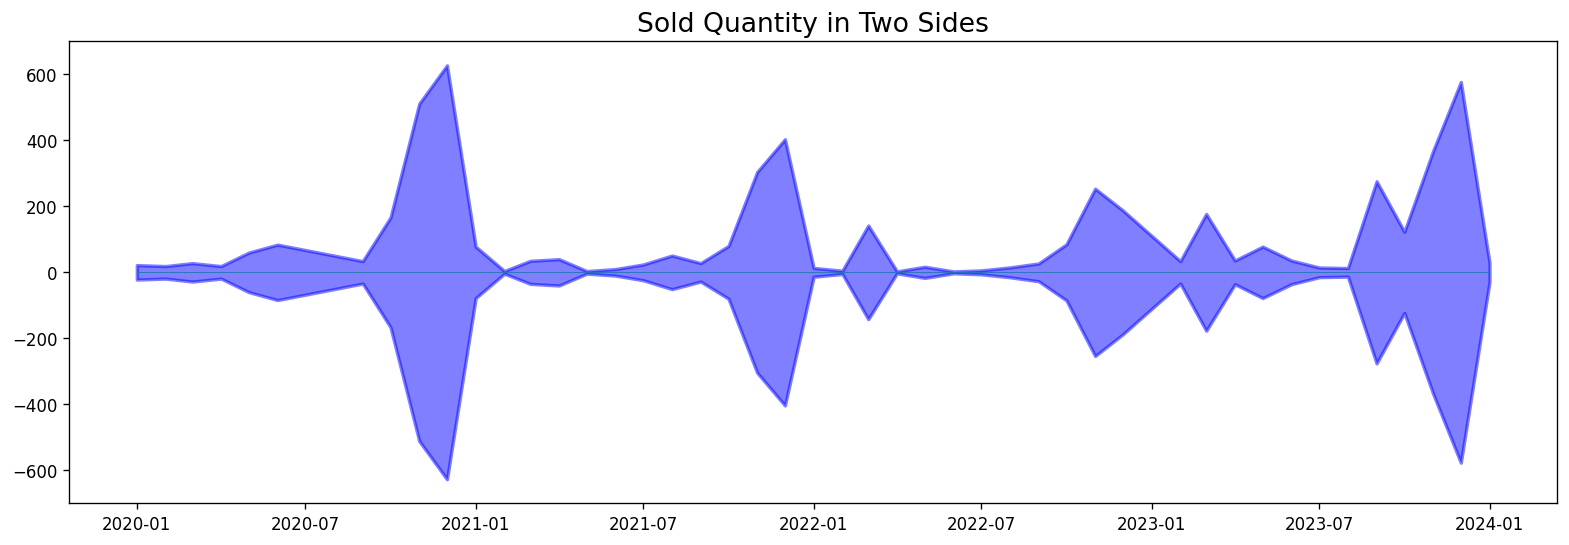

In [152]:
def two_sides(df):

    df = df[df['item_description'] == 'Botella_750ml']

    df = df[['date','sold_quantity']]
    df['first_day_of_month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    df = df.groupby(['first_day_of_month']).agg({'sold_quantity': 'sum'}).reset_index()

    x = df['first_day_of_month'].values
    y1 = df['sold_quantity'].values

    fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
    plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='blue')
    plt.ylim(-700, 700)
    plt.title('Sold Quantity in Two Sides', fontsize=16)
    plt.hlines(y=0, xmin=np.min(df['first_day_of_month']), xmax=np.max(df['first_day_of_month']), linewidth=.5)
    plt.show()

two_sides(stats)
    

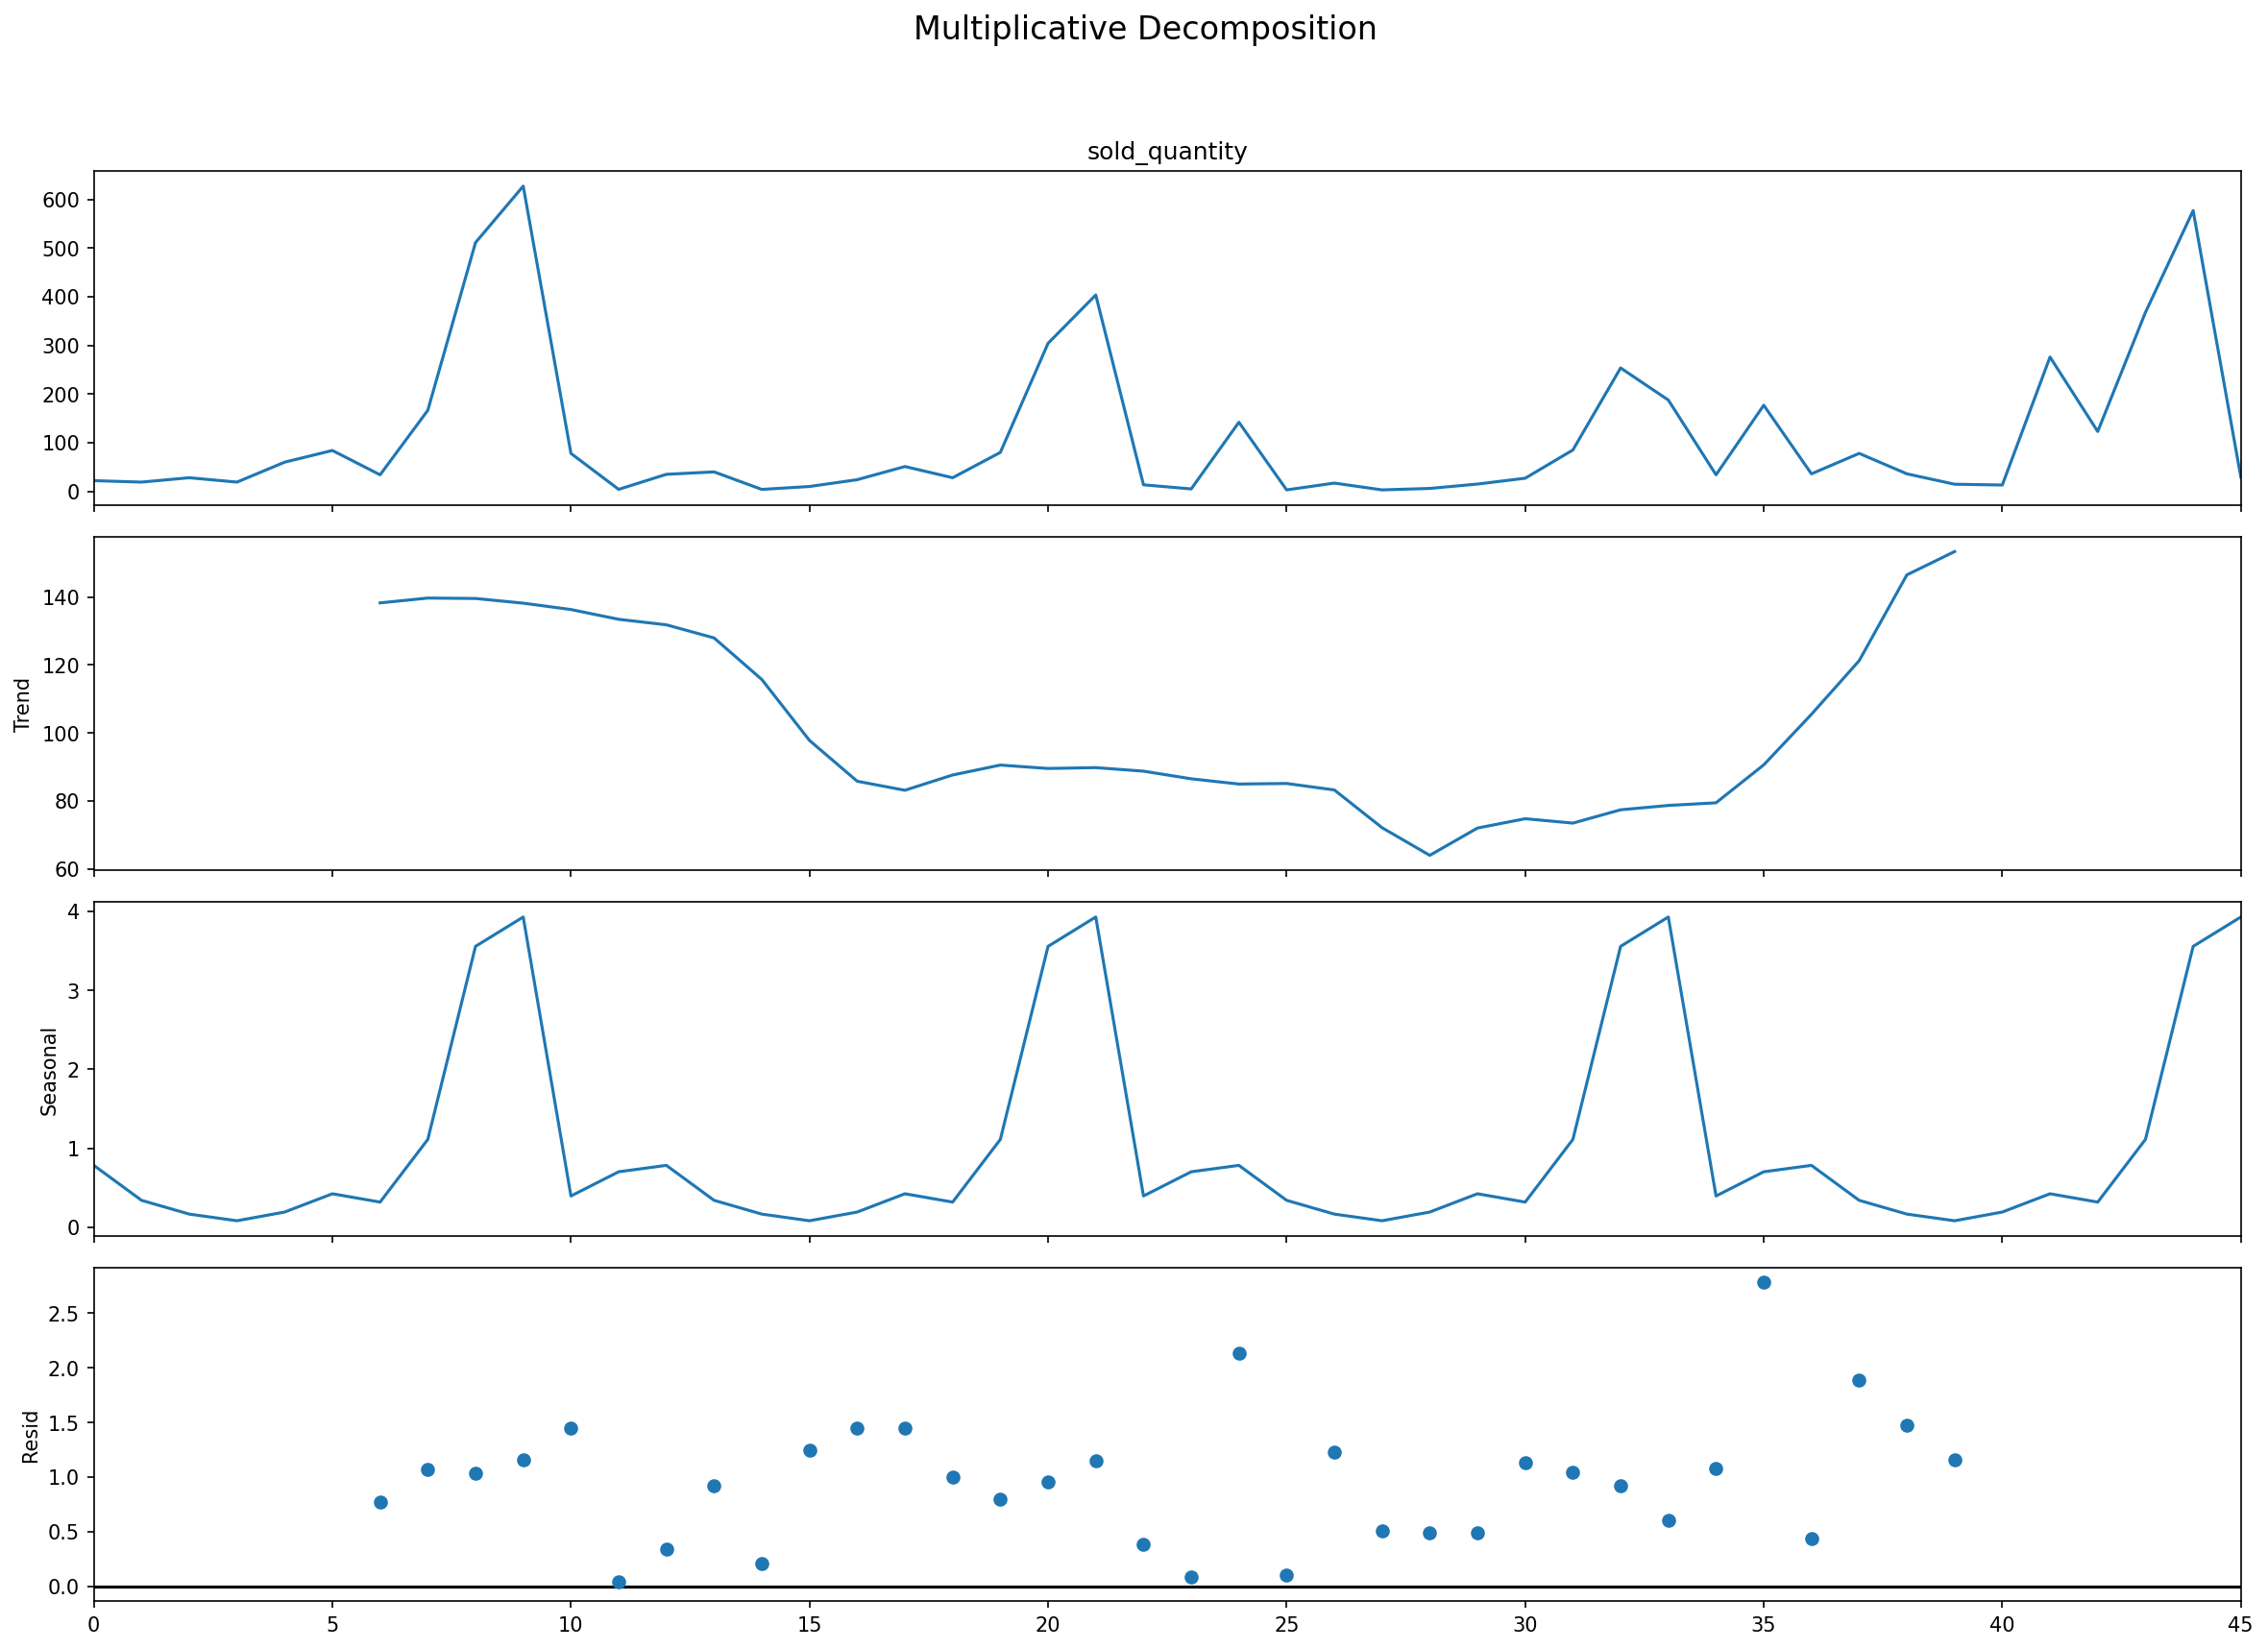

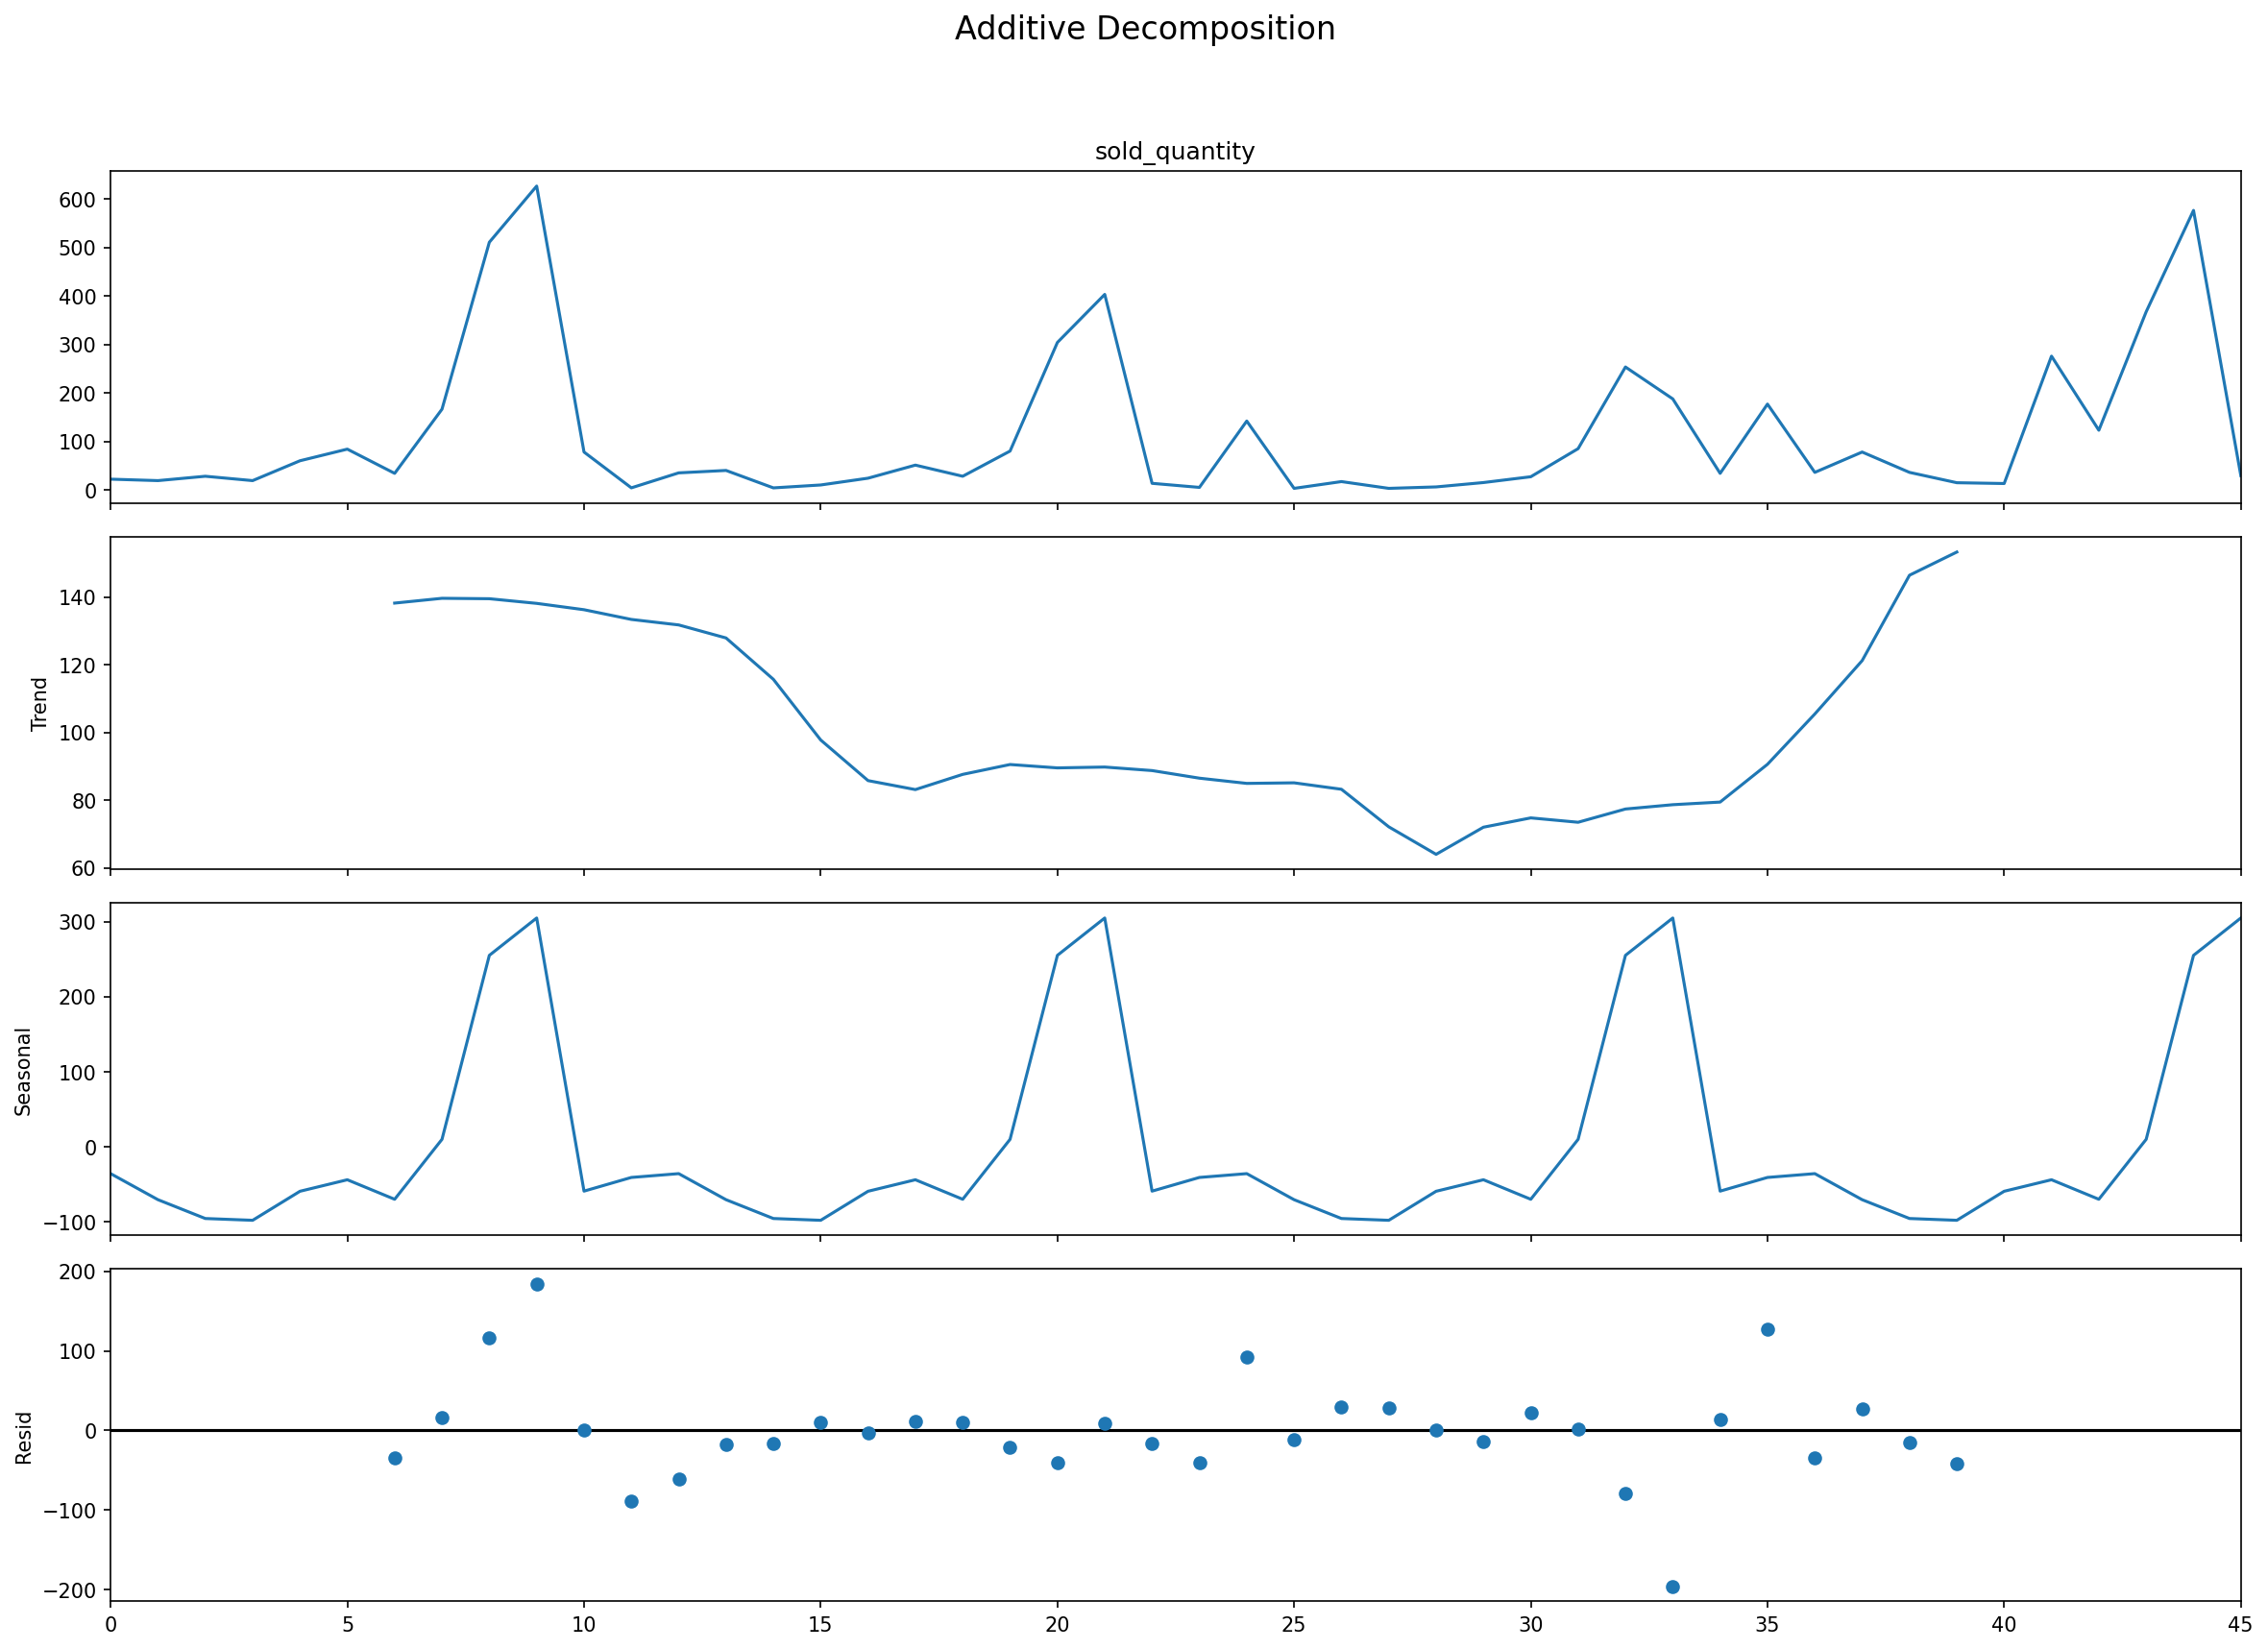

In [153]:
def decomposition_time_series(df):

    df = df[df['item_description'] == 'Botella_750ml']

    df = df[['date','sold_quantity']]
    df['first_day_of_month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    df = df.groupby(['first_day_of_month']).agg({'sold_quantity': 'sum'}).reset_index()

    x = df['first_day_of_month'].values
    y = df['sold_quantity'].values

    data = {'first_day_of_month': x, 'sold_quantity': y}
    df = pd.DataFrame(data)
   
    # Multiplicative Decomposition 
    multiplicative_decomposition = seasonal_decompose(df['sold_quantity'], model='multiplicative', period=12)

    # Additive Decomposition
    additive_decomposition = seasonal_decompose(df['sold_quantity'], model='additive', period=12)

    # Plot
    plt.rcParams.update({'figure.figsize': (16,12)})
    multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 0.99, 0.95])

    additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 0.99, 0.95])

    plt.show()

decomposition_time_series(stats)

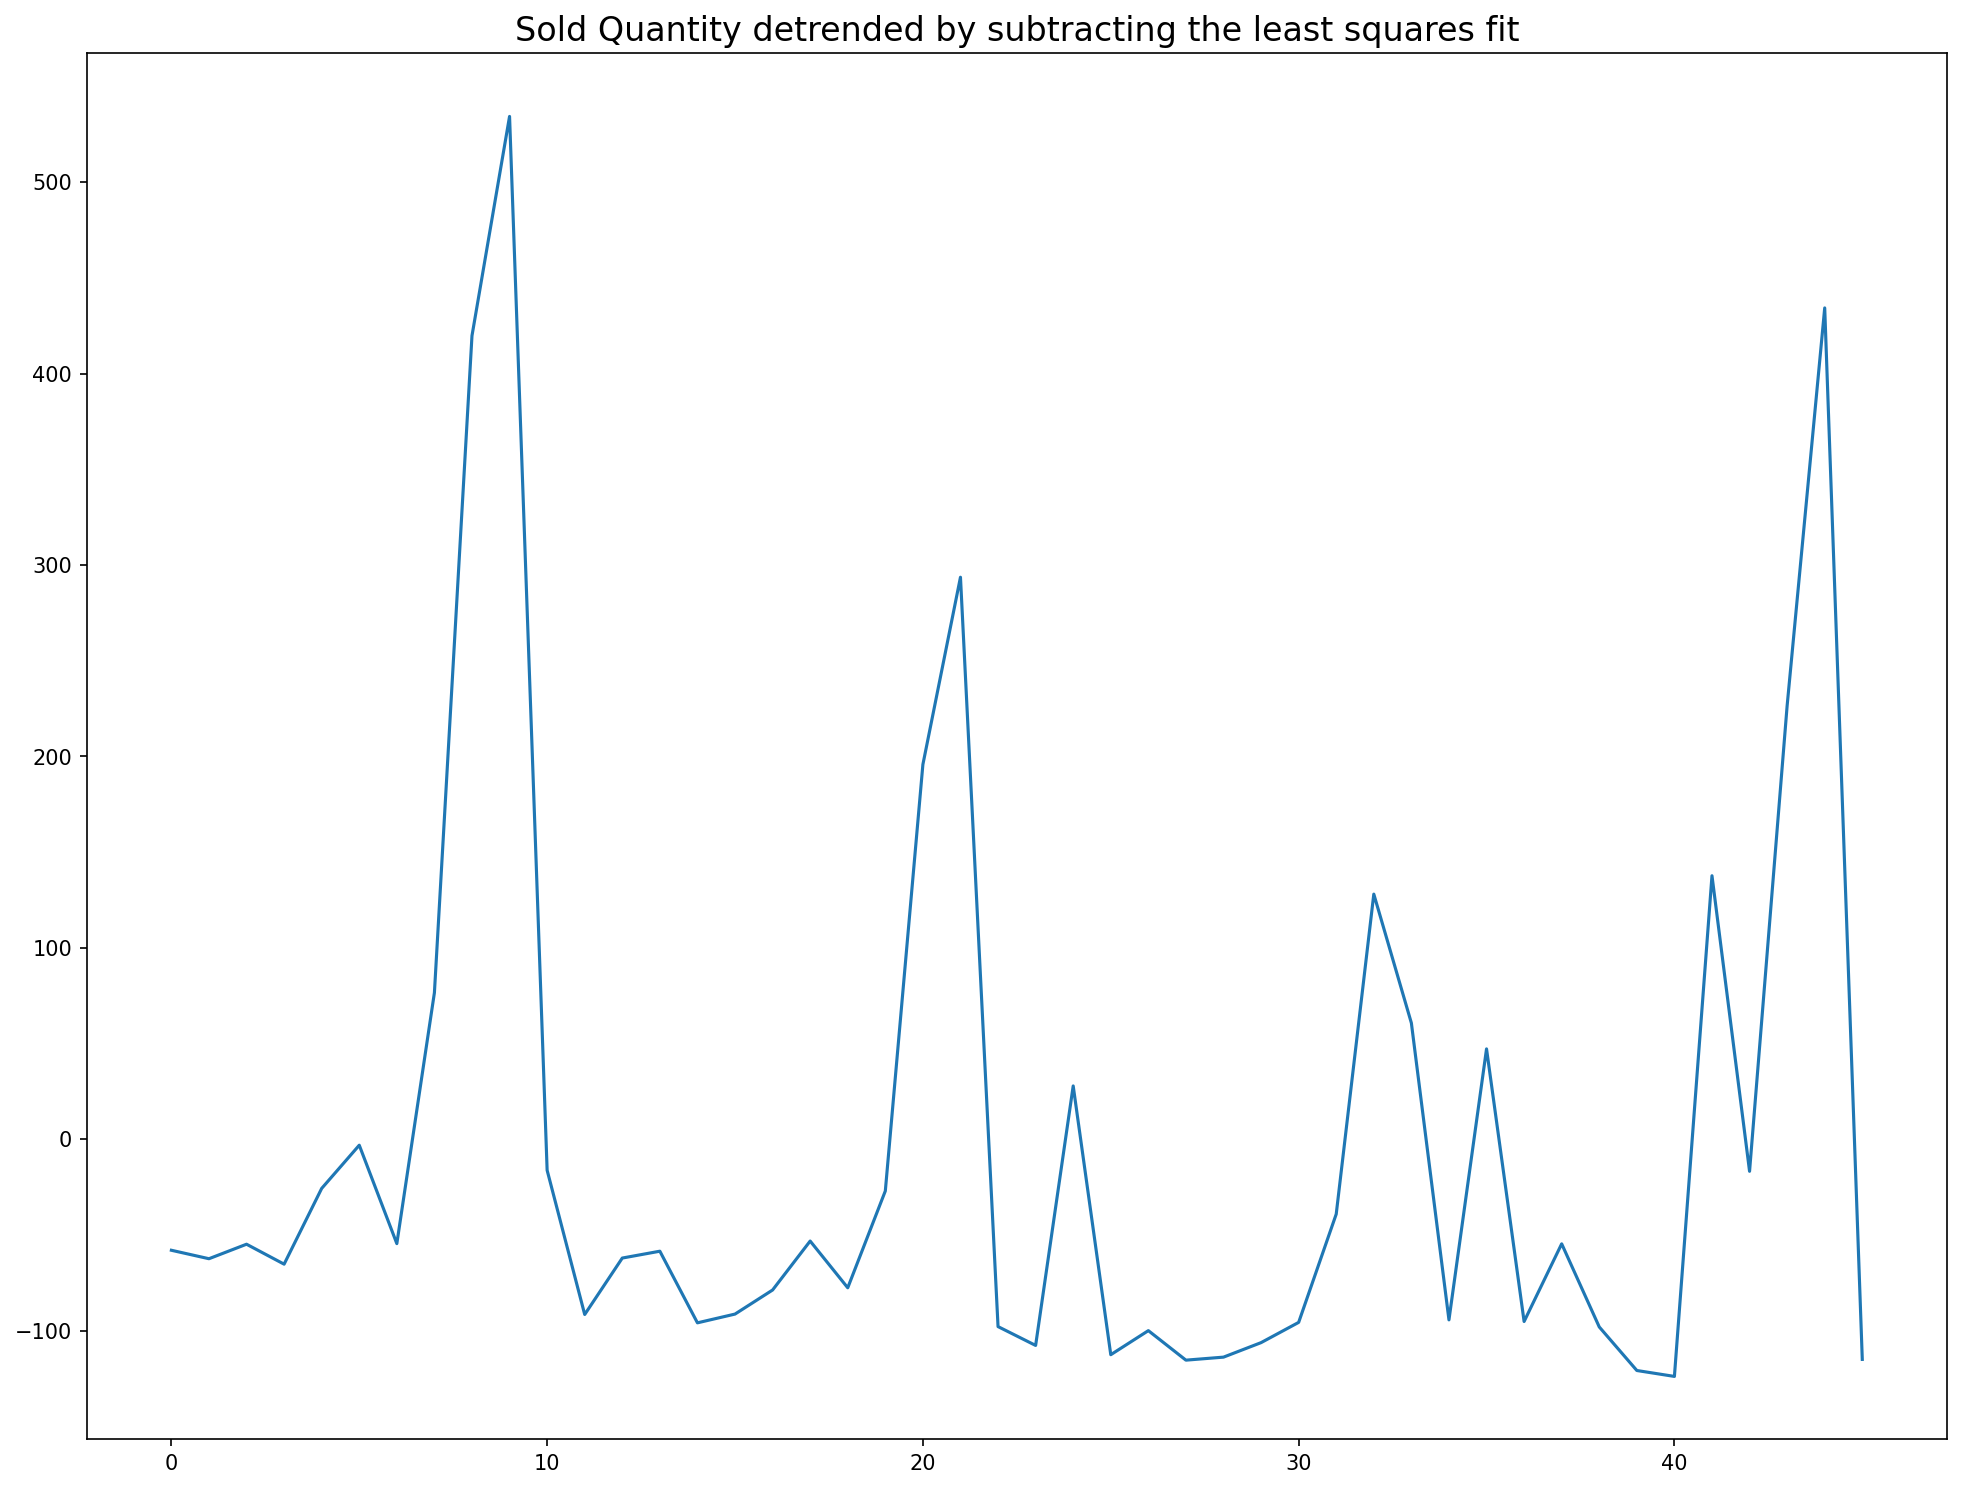

In [154]:
def signal_series(df):

    df = df[df['item_description'] == 'Botella_750ml']

    df = df[['date','sold_quantity']]
    df['first_day_of_month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    df = df.groupby(['first_day_of_month']).agg({'sold_quantity': 'sum'}).reset_index()

    x = df['first_day_of_month'].values
    y = df['sold_quantity'].values

    data = {'first_day_of_month': x, 'sold_quantity': y}
    df = pd.DataFrame(data)

    detrended = signal.detrend(df['sold_quantity'].values)
    plt.plot(detrended)
    plt.title('Sold Quantity detrended by subtracting the least squares fit', fontsize=16)

signal_series(stats)

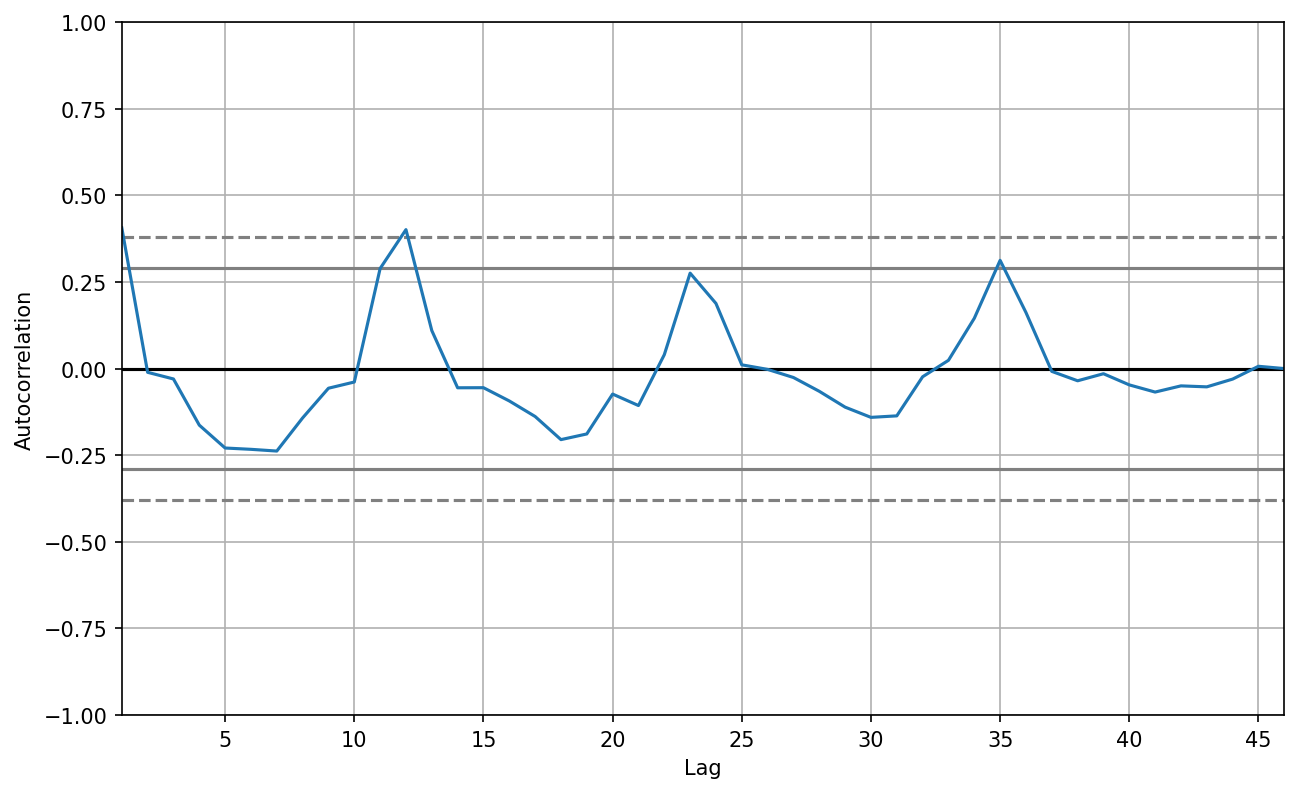

In [155]:
def autocorrelation(df):

    df = df[df['item_description'] == 'Botella_750ml']

    df = df[['date','sold_quantity']]
    df['first_day_of_month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    df = df.groupby(['first_day_of_month']).agg({'sold_quantity': 'sum'}).reset_index()

    x = df['first_day_of_month'].values
    y = df['sold_quantity'].values

    data = {'first_day_of_month': x, 'sold_quantity': y}
    df = pd.DataFrame(data)

    plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':150})
    autocorrelation_plot(df['sold_quantity'].tolist())

autocorrelation(stats)

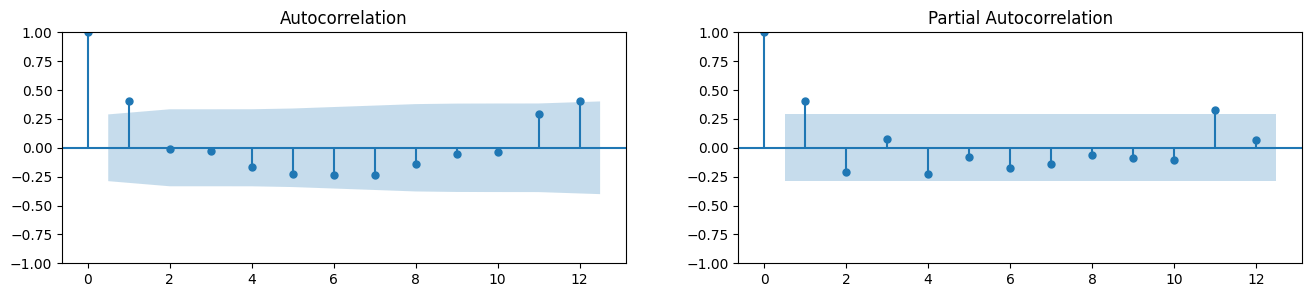

In [156]:
def autocorrelation_partialcorrelation(df):

    

    df = df[df['item_description'] == 'Botella_750ml']

    df = df[['date','sold_quantity']]
    df['first_day_of_month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    df = df.groupby(['first_day_of_month']).agg({'sold_quantity': 'sum'}).reset_index()

    x = df['first_day_of_month'].values
    y = df['sold_quantity'].values

    data = {'first_day_of_month': x, 'sold_quantity': y}
    df = pd.DataFrame(data)

    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
    plot_acf(df['sold_quantity'].tolist(), lags=12, ax=axes[0])
    plot_pacf(df['sold_quantity'].tolist(), lags=12, ax=axes[1])

autocorrelation_partialcorrelation(stats)

In [163]:
def adfuller_test(df):

    

    df = df[df['item_description'] == 'Botella_750ml']

    df = df[['date','sold_quantity']]
    df['first_day_of_month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    df = df.groupby(['first_day_of_month']).agg({'sold_quantity': 'sum'}).reset_index()

    x = df['first_day_of_month'].values
    y = df['sold_quantity'].values

    data = {'first_day_of_month': x, 'sold_quantity': y}
    df = pd.DataFrame(data)

    adf = adfuller(df['sold_quantity'])
    print("p-value of sold_quantity: {}".format(float(adf[1])))

    df.index = df['first_day_of_month']
    del df['first_day_of_month']

    adft = adfuller(df,autolag="AIC",maxlag=12)
    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print(output_df)

adfuller_test(stats)

p-value of sold_quantity: 0.6657263438034506
      Values                       Metric
0  -1.218181              Test Statistics
1   0.665726                      p-value
2  10.000000             No. of lags used
3  35.000000  Number of observations used
4  -3.632743          critical value (1%)
5  -2.948510          critical value (5%)
6  -2.613017         critical value (10%)
